# Задание 5

## Формулировка

*Свёрточные нейронные сети. Классификация изображений*

Реализуйте сверточную сеть со сверточными блоками двух видов:

+ $Conv2d-ReLU-MaxPool$
+ $Conv2d-ReLU-Conv2d-ReLU-MaxPool$

Для одной из выборок модуля [Datasets](https://pytorch.org/vision/stable/datasets.html) выберите сочетание следующих гиперпараметров нейронной сети, дающих наилучшее качество классификации:

1. Коэффициент обучения
2. Тип сверточных блоков и их количество
3. Параметры свертки (класс Conv2d):  

  3.1. Размер фильтра свертки (kernel_size)  
  3.2. Шаг фильтра свертки (stride)

4. Параметры пулинга (класс MaxPool):

  4.1. Размер фильтра пулинга (kernel_size)  
  4.2. Шаг фильтра пулинга (stride)

Оцените количество эпох достаточное для классификации с точностью не меньшей 90%

## Скачивание и подготовка выборки


+ Скачать выборку

In [ ]:
import torchvision
import torchvision.transforms as trnsfrms

train_dataset =  torchvision.datasets.mnist.MNIST(root='data', download=True, train=True, transform=trnsfrms.ToTensor())
test_dataset = torchvision.datasets.mnist.MNIST(root='data', train=False, transform=trnsfrms.ToTensor())

print(train_dataset)
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


+ Отображение выборки:

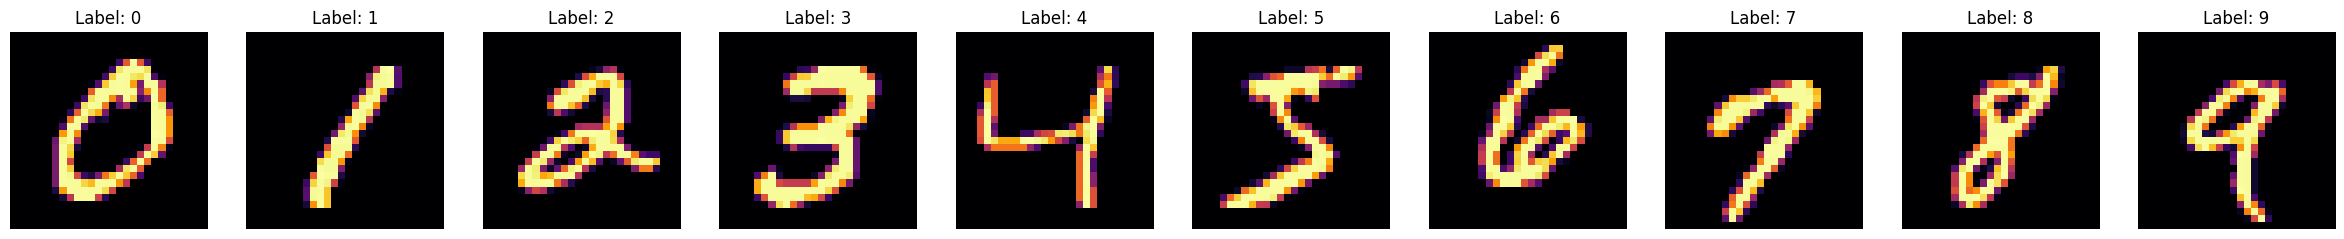

In [ ]:
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 10, figsize=(30, 12))
pil = ToPILImage()
for i in range(10):
    idx = (train_dataset.targets == i).nonzero()[0]
    image = pil(train_dataset.data[idx].reshape(28, 28))
    axes[i].imshow(image, cmap='inferno')
    axes[i].set_title(f"Label: {i}")
    axes[i].axis('off')
plt.show()

+ Преобразование выборки к необходимому виду:

In [ ]:
import torch
import numpy as np
full_train_x, full_train_y = train_dataset.data, train_dataset.targets
full_test_x, full_test_y = test_dataset.data, test_dataset.targets

digit_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
train_ind = [i for i, label in enumerate(full_train_y) if label in digit_labels]
test_ind = [i for i, label in enumerate(full_test_y) if label in digit_labels]

train_x, dig_train_y = full_train_x[train_ind], full_train_y[train_ind]
test_x, dig_test_y = full_test_x[test_ind], full_test_y[test_ind]

# Преобразуем данные в формат [batch_size, 1, 28, 28]
train_x = train_x.float().unsqueeze(1) / 255.0
test_x = test_x.float().unsqueeze(1) / 255.0

# Вывод размеров тензоров
print(f'Size of train_x: {train_x.shape}')
print(f'Size of test_x: {test_x.shape}')


Size of train_x: torch.Size([60000, 1, 28, 28])
Size of test_x: torch.Size([10000, 1, 28, 28])


## Реализация сверточных сетей

Этот класс предназначен для "вытягивания" (flattening) тензоров, превращая их из многомерных в одномерные. Он будет использоваться в составе нейронных сетей для преобразования выходных данных из сверточных слоев перед подачей их на полносвязные слои.

In [ ]:
import PIL.ImageOps
import torch.nn as nn
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

class Flatten(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor):
        return x.view(x.size(0), -1)

nn.Conv2d: Сверточный слой с *in_channels* входными каналами (предполагается RGB-изображение), *out_channels* выходными каналами, ядром свертки размером *kernel_conv_size* и шагом фильтра *stride_conv*.

nn.ReLU: Функция активации ReLU, которая добавляется после каждого сверточного слоя.

nn.MaxPool2d: Слой подвыборки, использующий операцию максимального пулинга с ядром размером *kernel_pool_size* и шагом фильтра *stride_pool*.

Flatten: Слой, определенный в предыдущем коде, который "сплющивает" данные перед подачей их на полносвязные слои.

nn.Linear: Полносвязный слои

In [36]:
class CNN(nn.Module):
    def __init__(self, num_of_blocks, stride_conv, stride_pool, kernel_conv_size, kernel_pool_size, out_channels=6, in_channels=1):
        super(CNN, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_conv_size, stride=stride_conv),
            nn.ReLU(),
            nn.MaxPool2d(kernel_pool_size, stride=stride_pool)
        ]

        for _ in range(num_of_blocks - 1):
            layers.extend([
                nn.Conv2d(out_channels, out_channels, kernel_conv_size, stride=stride_conv),
                nn.ReLU(),
                nn.MaxPool2d(kernel_pool_size, stride=stride_pool)
            ])

        layers.append(nn.Flatten())

        self.model = nn.Sequential(*layers)

        with torch.no_grad():
            sample_input = torch.zeros(out_channels, in_channels, 28, 28)
            sample_output = self.model(sample_input)
            linear_input_dim = sample_output.shape[1]

        self.fc = nn.Sequential(
            nn.Linear(linear_input_dim, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        return x

    def fit(self, X, Y, epochs, lr, batch_size=100, logs=True):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X, Y = X[indices], Y[indices]
            for i in range(X.shape[0] // batch_size):
                x, y = X[i * batch_size:(i + 1) * batch_size], Y[i * batch_size:(i + 1) * batch_size]
                optimizer.zero_grad()
                pred = self(x)
                loss = criterion(pred, y)
                loss.backward()
                optimizer.step()
            if logs:
                print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    def predict(self, X):
        with torch.no_grad():
            return self(X).argmax(dim=1)

Визуализация матрицы ошибок (confusion matrix) между предсказанными метками (y_pred) и истинными метками (y_true)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

def draw_confusion_matrix(y_pred, y_true):
    with torch.no_grad():
        matrix = confusion_matrix(y_true, y_pred)
        ConfusionMatrixDisplay(matrix, display_labels=range(10)).plot(include_values=True, cmap='Blues')

## Подбор параметров

+ Подбор *learning rate*

Epoch 1/10, Loss: 0.016937144100666046
Epoch 2/10, Loss: 0.002718268893659115
Epoch 3/10, Loss: 0.0888710767030716
Epoch 4/10, Loss: 0.0002635583805385977
Epoch 5/10, Loss: 0.10365940630435944
Epoch 6/10, Loss: 0.018030045554041862
Epoch 7/10, Loss: 0.0021464545279741287
Epoch 8/10, Loss: 0.00311244442127645
Epoch 9/10, Loss: 7.080723298713565e-05
Epoch 10/10, Loss: 0.012364417314529419
Accuracy with learning rate 0.3: 0.9838
Epoch 1/10, Loss: 0.14164598286151886
Epoch 2/10, Loss: 0.04324018210172653
Epoch 3/10, Loss: 0.016184957697987556
Epoch 4/10, Loss: 0.05381297320127487
Epoch 5/10, Loss: 0.016500793397426605
Epoch 6/10, Loss: 0.00039227059460245073
Epoch 7/10, Loss: 0.013907097280025482
Epoch 8/10, Loss: 0.004542800132185221
Epoch 9/10, Loss: 0.00507277250289917
Epoch 10/10, Loss: 0.0007603435078635812
Accuracy with learning rate 0.1: 0.9887
Epoch 1/10, Loss: 0.03893989324569702
Epoch 2/10, Loss: 0.13398824632167816
Epoch 3/10, Loss: 0.04539823159575462
Epoch 4/10, Loss: 0.090667

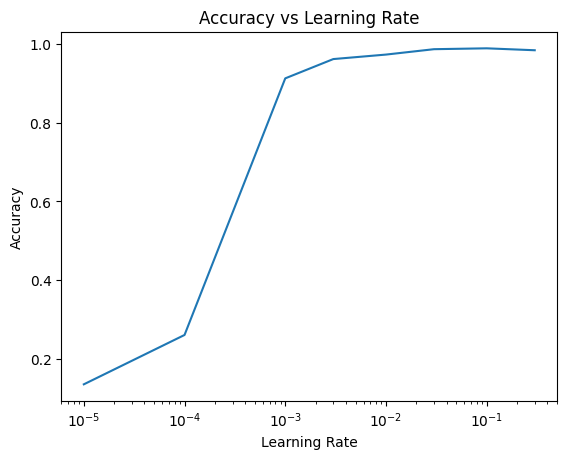

In [ ]:
lrs = [0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0001, 0.00001]
accuracy_scores = []

for lr in lrs:
    model = CNN(num_of_blocks=1, stride_conv=1, stride_pool=2, kernel_conv_size=5, kernel_pool_size=2, out_channels=6, in_channels=1)
    model.fit(train_x, dig_train_y, epochs=10, lr=lr, batch_size=32)
    with torch.no_grad():
        pred = model.predict(test_x).numpy()
        test_y_labels = dig_test_y.numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with learning rate {lr}: {accuracy}')

max_lr = lrs[accuracy_scores.index(max(accuracy_scores))]
print(f'Best learning rate: {max_lr}')

plt.plot(lrs, accuracy_scores)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Learning Rate')
plt.show()

+ Подбор *batch size*

Epoch 1/10, Loss: 0.046840034425258636
Epoch 2/10, Loss: 0.005709579214453697
Epoch 3/10, Loss: 0.022044042125344276
Epoch 4/10, Loss: 0.008152652531862259
Epoch 5/10, Loss: 0.020241394639015198
Epoch 6/10, Loss: 9.592894639354199e-05
Epoch 7/10, Loss: 0.18739478290081024
Epoch 8/10, Loss: 0.16064006090164185
Epoch 9/10, Loss: 0.002194164087995887
Epoch 10/10, Loss: 2.9457491109496914e-05
Accuracy with batch size 16: 0.9863
Epoch 1/10, Loss: 0.02510923519730568
Epoch 2/10, Loss: 0.12383648008108139
Epoch 3/10, Loss: 0.015062003396451473
Epoch 4/10, Loss: 0.00028898054733872414
Epoch 5/10, Loss: 0.004189965780824423
Epoch 6/10, Loss: 0.006421806290745735
Epoch 7/10, Loss: 0.0032642721198499203
Epoch 8/10, Loss: 0.02847602218389511
Epoch 9/10, Loss: 0.2114585041999817
Epoch 10/10, Loss: 0.004471370484679937
Accuracy with batch size 32: 0.9864
Epoch 1/10, Loss: 0.2628113925457001
Epoch 2/10, Loss: 0.07648052275180817
Epoch 3/10, Loss: 0.045105718076229095
Epoch 4/10, Loss: 0.0078289676457

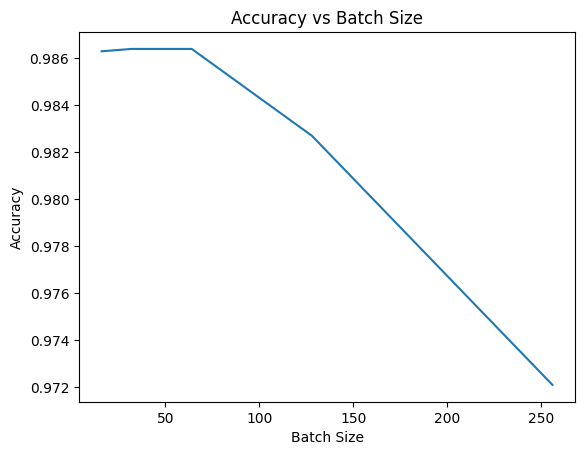

In [ ]:
batch_sizes = [16, 32, 64, 128, 256]
accuracy_scores = []

for batch_size in batch_sizes:
    model = CNN(num_of_blocks=1, stride_conv=1, stride_pool=2, kernel_conv_size=5, kernel_pool_size=2, out_channels=6, in_channels=1)
    model.fit(train_x, dig_train_y, epochs=10, lr=max_lr, batch_size=batch_size)
    with torch.no_grad():
        pred = model.predict(test_x).numpy()
        test_y_labels = dig_test_y.numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with batch size {batch_size}: {accuracy}')

max_batch_size = batch_sizes[accuracy_scores.index(max(accuracy_scores))]
print(f'Best batch size: {max_batch_size}')

plt.plot(batch_sizes, accuracy_scores)
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Batch Size')
plt.show()

+ Подбор *conv_kernel_sizes*:

Epoch 1/10, Loss: 0.10343608260154724
Epoch 2/10, Loss: 0.01186070591211319
Epoch 3/10, Loss: 0.11087628453969955
Epoch 4/10, Loss: 0.20169328153133392
Epoch 5/10, Loss: 0.0021391119807958603
Epoch 6/10, Loss: 0.11343520134687424
Epoch 7/10, Loss: 0.0010157030774280429
Epoch 8/10, Loss: 7.863979408284649e-05
Epoch 9/10, Loss: 0.0005088450852781534
Epoch 10/10, Loss: 9.752516052685678e-05
Accuracy with convolution kernel size 3: 0.9863
Epoch 1/10, Loss: 0.06096038967370987
Epoch 2/10, Loss: 0.0068833171389997005
Epoch 3/10, Loss: 0.010711336508393288
Epoch 4/10, Loss: 0.0033831277396529913
Epoch 5/10, Loss: 0.12335202097892761
Epoch 6/10, Loss: 0.0017863765824586153
Epoch 7/10, Loss: 0.0021926157642155886
Epoch 8/10, Loss: 0.02951710671186447
Epoch 9/10, Loss: 2.312051219632849e-05
Epoch 10/10, Loss: 0.000183238327736035
Accuracy with convolution kernel size 5: 0.9888
Epoch 1/10, Loss: 0.05408095568418503
Epoch 2/10, Loss: 0.004514203406870365
Epoch 3/10, Loss: 0.01728907600045204
Epoch

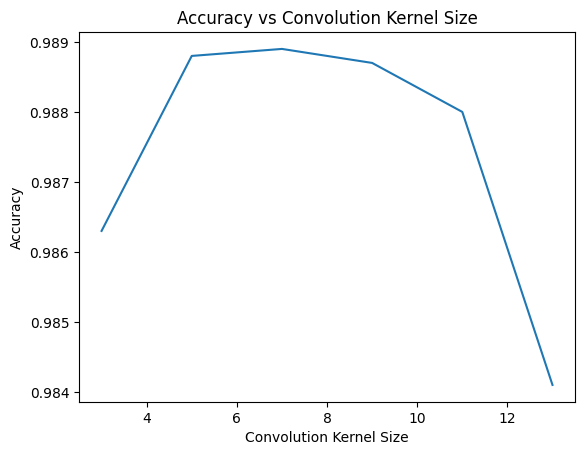

In [ ]:
conv_kernel_sizes = [3, 5, 7, 9, 11, 13]
accuracy_scores = []

for conv_kernel_size in conv_kernel_sizes:
    model = CNN(num_of_blocks=1, stride_conv=1, stride_pool=2, kernel_conv_size=conv_kernel_size, kernel_pool_size=2, out_channels=6, in_channels=1)
    model.fit(train_x, dig_train_y, epochs=10, lr=max_lr, batch_size=max_batch_size)
    with torch.no_grad():
        pred = model.predict(test_x).numpy()
        test_y_labels = dig_test_y.numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with convolution kernel size {conv_kernel_size}: {accuracy}')

max_conv_kernel_size = conv_kernel_sizes[accuracy_scores.index(max(accuracy_scores))]
print(f'Best convolution kernel size: {max_conv_kernel_size}')

plt.plot(conv_kernel_sizes, accuracy_scores)
plt.xlabel('Convolution Kernel Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Convolution Kernel Size')
plt.show()

+ Подбор *conv_stride*

Epoch 1/10, Loss: 0.07177821546792984
Epoch 2/10, Loss: 0.013135942630469799
Epoch 3/10, Loss: 0.003296859096735716
Epoch 4/10, Loss: 0.0007276080432347953
Epoch 5/10, Loss: 0.0002917388337664306
Epoch 6/10, Loss: 0.0009246405097655952
Epoch 7/10, Loss: 0.003447804367169738
Epoch 8/10, Loss: 0.041020505130290985
Epoch 9/10, Loss: 0.0001221349521074444
Epoch 10/10, Loss: 0.010955018922686577
Accuracy with convolution stride 1: 0.9887
Epoch 1/10, Loss: 0.06632894277572632
Epoch 2/10, Loss: 0.13278008997440338
Epoch 3/10, Loss: 0.08541716635227203
Epoch 4/10, Loss: 0.11025749146938324
Epoch 5/10, Loss: 0.002003507222980261
Epoch 6/10, Loss: 0.08090423047542572
Epoch 7/10, Loss: 0.0065865954384207726
Epoch 8/10, Loss: 0.0072813015431165695
Epoch 9/10, Loss: 0.013018830679357052
Epoch 10/10, Loss: 0.00047167445882223547
Accuracy with convolution stride 2: 0.9869
Epoch 1/10, Loss: 0.05132152885198593
Epoch 2/10, Loss: 0.09626954048871994
Epoch 3/10, Loss: 0.13687607645988464
Epoch 4/10, Loss

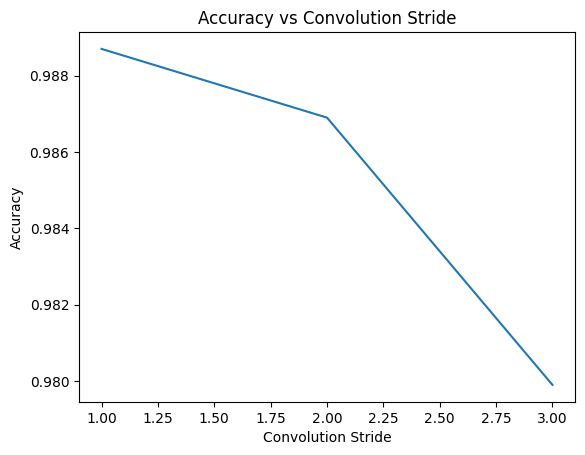

In [ ]:
conv_strides = [1, 2, 3]
accuracy_scores = []

for conv_stride in conv_strides:
    model = CNN(num_of_blocks=1, stride_conv=conv_stride, stride_pool=2, kernel_conv_size=max_conv_kernel_size, kernel_pool_size=2, out_channels=6, in_channels=1)
    model.fit(train_x, dig_train_y, epochs=10, lr=max_lr, batch_size=max_batch_size)
    with torch.no_grad():
        pred = model.predict(test_x).numpy()
        test_y_labels = dig_test_y.numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with convolution stride {conv_stride}: {accuracy}')

max_conv_stride = conv_strides[accuracy_scores.index(max(accuracy_scores))]
print(f'Best convolution stride: {max_conv_stride}')

plt.plot(conv_strides, accuracy_scores)
plt.xlabel('Convolution Stride')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Convolution Stride')
plt.show()

+ Подбор *pool_kernel_size*

Epoch 1/10, Loss: 0.3315051794052124
Epoch 2/10, Loss: 0.08681469410657883
Epoch 3/10, Loss: 0.028001900762319565
Epoch 4/10, Loss: 0.031858738511800766
Epoch 5/10, Loss: 0.0033379753585904837
Epoch 6/10, Loss: 0.0711035430431366
Epoch 7/10, Loss: 0.005518650636076927
Epoch 8/10, Loss: 0.029421966522932053
Epoch 9/10, Loss: 0.01088639348745346
Epoch 10/10, Loss: 9.579206380294636e-05
Accuracy with pool kernel size 2: 0.9859
Epoch 1/10, Loss: 0.011322771199047565
Epoch 2/10, Loss: 0.011743986047804356
Epoch 3/10, Loss: 0.0017422869568690658
Epoch 4/10, Loss: 0.029948635026812553
Epoch 5/10, Loss: 0.0309982318431139
Epoch 6/10, Loss: 0.0023798379115760326
Epoch 7/10, Loss: 0.005312982946634293
Epoch 8/10, Loss: 0.005642353091388941
Epoch 9/10, Loss: 0.06345928460359573
Epoch 10/10, Loss: 0.0034333146177232265
Accuracy with pool kernel size 3: 0.9888
Epoch 1/10, Loss: 0.026095308363437653
Epoch 2/10, Loss: 0.030649982392787933
Epoch 3/10, Loss: 0.0015727810095995665
Epoch 4/10, Loss: 0.00

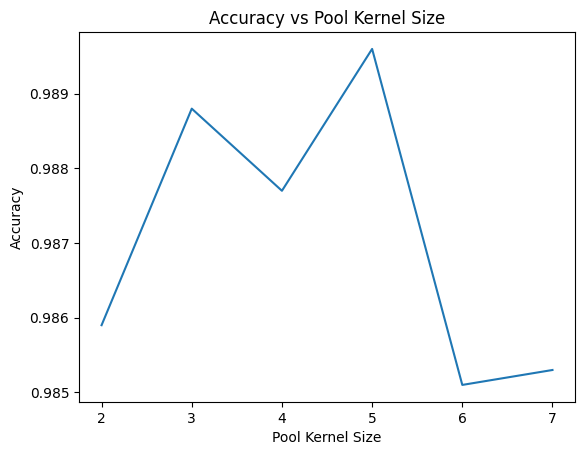

In [ ]:
pool_kernel_sizes = [2, 3, 4, 5, 6, 7]
accuracy_scores = []

for pool_kernel_size in pool_kernel_sizes:
    model = CNN(num_of_blocks=1, stride_conv=max_conv_stride, stride_pool=2, kernel_conv_size=max_conv_kernel_size, kernel_pool_size=pool_kernel_size, out_channels=6, in_channels=1)
    model.fit(train_x, dig_train_y, epochs=10, lr=max_lr, batch_size=max_batch_size)
    with torch.no_grad():
        pred = model.predict(test_x).numpy()
        test_y_labels = dig_test_y.numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with pool kernel size {pool_kernel_size}: {accuracy}')

max_pool_kernel_size = pool_kernel_sizes[accuracy_scores.index(max(accuracy_scores))]
print(f'Best pool kernel size: {max_pool_kernel_size}')

plt.plot(pool_kernel_sizes, accuracy_scores)
plt.xlabel('Pool Kernel Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Pool Kernel Size')
plt.show()


+ Подбор *pool_stride*

Epoch 1/10, Loss: 0.024245157837867737
Epoch 2/10, Loss: 0.002151868771761656
Epoch 3/10, Loss: 0.006752188317477703
Epoch 4/10, Loss: 0.15789107978343964
Epoch 5/10, Loss: 0.10249895602464676
Epoch 6/10, Loss: 0.008134601637721062
Epoch 7/10, Loss: 0.0008362937951460481
Epoch 8/10, Loss: 0.006301881279796362
Epoch 9/10, Loss: 0.006714576855301857
Epoch 10/10, Loss: 0.00017706734070088714
Accuracy with pool stride 1: 0.9864
Epoch 1/10, Loss: 0.031163286417722702
Epoch 2/10, Loss: 0.14017926156520844
Epoch 3/10, Loss: 0.016408676281571388
Epoch 4/10, Loss: 0.08901998400688171
Epoch 5/10, Loss: 0.026636794209480286
Epoch 6/10, Loss: 0.10594578087329865
Epoch 7/10, Loss: 0.0006370209739543498
Epoch 8/10, Loss: 0.00032668508356437087
Epoch 9/10, Loss: 0.011368849314749241
Epoch 10/10, Loss: 0.0005050096078775823
Accuracy with pool stride 2: 0.989
Epoch 1/10, Loss: 0.06687638908624649
Epoch 2/10, Loss: 0.12482679635286331
Epoch 3/10, Loss: 0.008058787323534489
Epoch 4/10, Loss: 0.0069789392

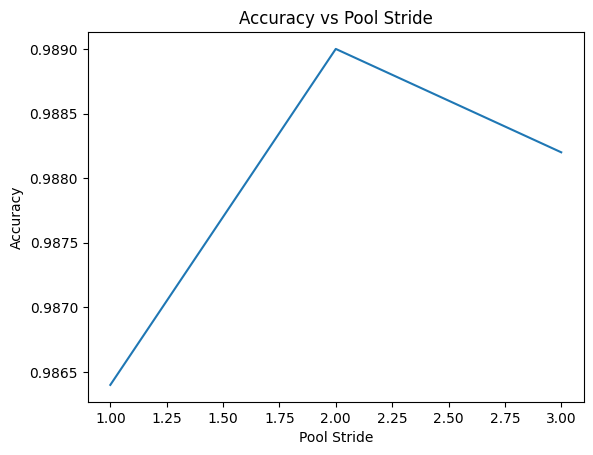

In [ ]:
pool_strides = [1, 2, 3]
accuracy_scores = []

for pool_stride in pool_strides:
    model = CNN(num_of_blocks=1, stride_conv=max_conv_stride, stride_pool=pool_stride, kernel_conv_size=max_conv_kernel_size, kernel_pool_size=max_pool_kernel_size, out_channels=6, in_channels=1)
    model.fit(train_x, dig_train_y, epochs=10, lr=max_lr, batch_size=max_batch_size)
    with torch.no_grad():
        pred = model.predict(test_x).numpy()
        test_y_labels = dig_test_y.numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with pool stride {pool_stride}: {accuracy}')

max_pool_stride = pool_strides[accuracy_scores.index(max(accuracy_scores))]
print(f'Best pool stride: {max_pool_stride}')

plt.plot(pool_strides, accuracy_scores)
plt.xlabel('Pool Stride')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Pool Stride')
plt.show()


+ Подбор *epochs*

blocks_num=1, conv_stride=1, pool_stride=2, conv_kernel_size=7, pool_kernel_size=5
Iteration: 1
Epoch 1/10, Loss: 0.2166951596736908
Epoch 2/10, Loss: 0.014038247056305408
Epoch 3/10, Loss: 0.014572271145880222
Epoch 4/10, Loss: 0.13628073036670685
Epoch 5/10, Loss: 0.0020806335378438234
Epoch 6/10, Loss: 0.04173468425869942
Epoch 7/10, Loss: 0.0007367905345745385
Epoch 8/10, Loss: 0.00045009327004663646
Epoch 9/10, Loss: 0.002060574945062399
Epoch 10/10, Loss: 0.005943107884377241
Accuracy: 0.9908


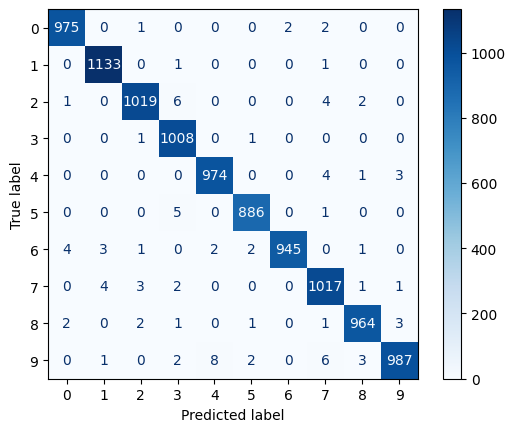

In [38]:
print(f'blocks_num={1}, conv_stride={max_conv_stride}, pool_stride={max_pool_stride}, conv_kernel_size={max_conv_kernel_size}, pool_kernel_size={max_pool_kernel_size}')
model = CNN(1, max_conv_stride, max_pool_stride, max_conv_kernel_size, max_pool_kernel_size)

for i in range(10):
    print(f'Iteration: {i+1}')
    model.fit(train_x, dig_train_y, 10, max_lr, max_batch_size)

    pred = model.predict(test_x).numpy()
    test_y_labels = dig_test_y.numpy()

    accuracy = accuracy_score(test_y_labels, pred)
    print(f'Accuracy: {accuracy}')

    if accuracy > 0.9:
      break

with torch.no_grad():
    pred = model.predict(test_x).numpy()
    draw_confusion_matrix(pred, dig_test_y.numpy())